<a href="https://colab.research.google.com/github/dibadabir/Project1_A24/blob/main/Final_VGG_for_cancerous_clas_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 1467 images belonging to 3 classes.
Found 315 images belonging to 3 classes.
Found 318 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 320ms/step - accuracy: 0.4668 - loss: 1.1081 - val_accuracy: 0.6730 - val_loss: 0.8089 - learning_rate: 1.0000e-04
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 267ms/step - accuracy: 0.7692 - loss: 0.6445 - val_accuracy: 0.7778 - val_loss: 0.6271 - learning_rate: 1.0000e-04
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 275ms/step - accuracy: 0.8103 - loss: 0.5302 - val_accuracy: 0.8540 - val_loss: 0.4465 - learning_rate: 1.0000e-04
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 272ms/step - accuracy: 0.8759 - loss: 0.3977 - val_accuracy: 0.8444 - val_loss: 0.4037 - learning_rate: 1.0000e-04
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step - accuracy: 0.9001 - loss: 0.3107 - val_accuracy: 0.8921 - val_loss: 0.3731 - learning_rate: 1.0000e-04
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 261ms/step - accuracy: 0.9321 - loss: 0.2423 - val_accuracy: 0.9238 - val_loss: 0.2838 - learning_rate: 1.0000e-04
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 259ms/step - acc

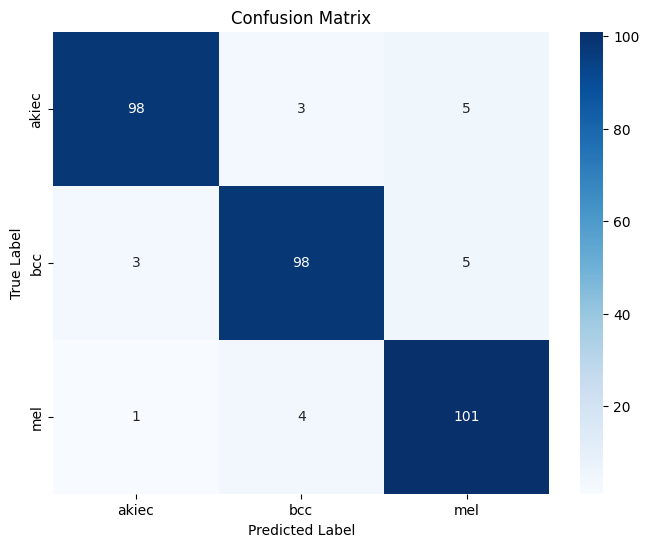

              precision    recall  f1-score   support

       akiec       0.96      0.92      0.94       106
         bcc       0.93      0.92      0.93       106
         mel       0.91      0.95      0.93       106

    accuracy                           0.93       318
   macro avg       0.93      0.93      0.93       318
weighted avg       0.93      0.93      0.93       318



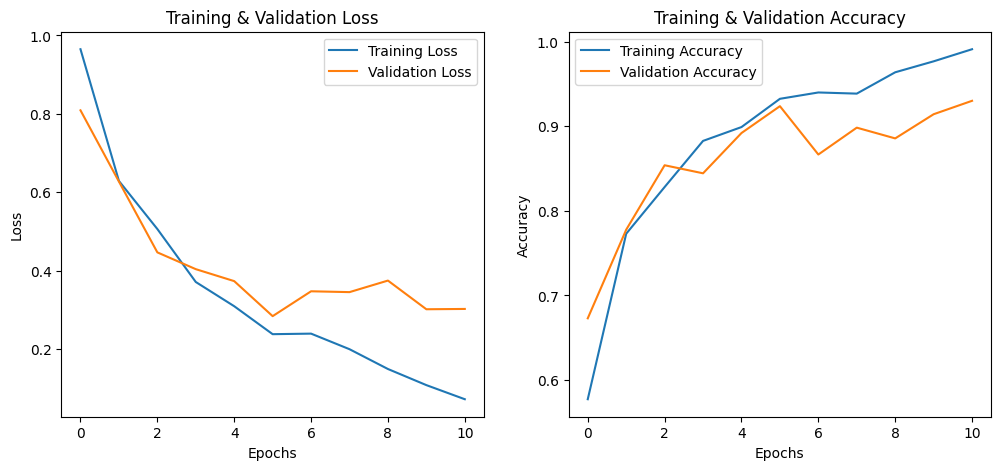

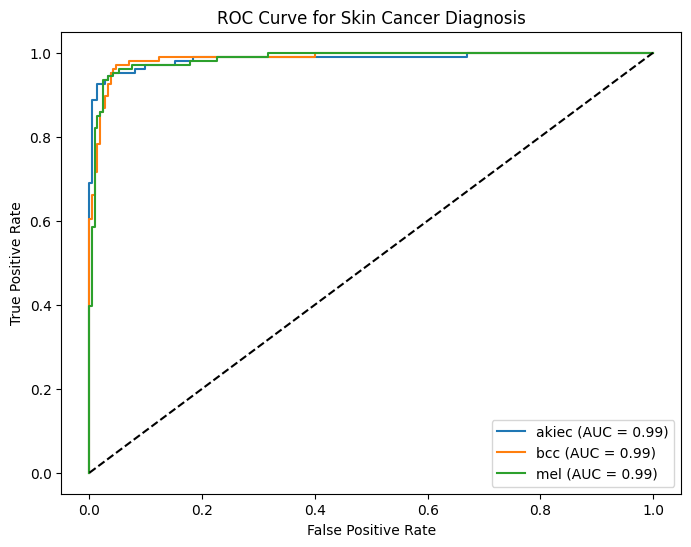

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize

# ---------------------------
# 1. Building CNN model using VGG16
# ---------------------------
def build_vgg16_model(input_shape=(224, 224, 3), num_classes=3):
    # Load the VGG16 model with weights pretrained on ImageNet and exclude the top fully-connected layers.
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers in the base model to retain pretrained features during initial training.
    for layer in base_model.layers:
        layer.trainable = False

    # Add a custom classification head with L2 regularization and dropout to reduce overfitting.
    x = layers.GlobalAveragePooling2D()(base_model.output)
    # Fully connected layer with 1024 neurons, ReLU activation and L2 regularization.
    x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    # Apply dropout with a rate of 0.6.
    x = layers.Dropout(0.6)(x)
    # Final classification layer.
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Assemble the complete model.
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

# Build and compile the model with the specified input shape and number of classes.
model = build_vgg16_model(input_shape=(224, 224, 3), num_classes=3)

# Unfreeze the last 10 layers to allow fine-tuning.
for layer in model.layers[-10:]:
    layer.trainable = True

# Set learning rate (LR) to 1e-4.
LR = 1e-4
optimizer = Adam(learning_rate=LR)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ---------------------------
# 2. Loading dataset and computing class weights
# ---------------------------
train_dir = '/content/drive/MyDrive/Discipline-specific/split_dataset/train'
val_dir   = '/content/drive/MyDrive/Discipline-specific/split_dataset/val'
test_dir  = '/content/drive/MyDrive/Discipline-specific/split_dataset/test'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen   = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32, class_mode='categorical')
val_generator   = val_datagen.flow_from_directory(val_dir, target_size=(224,224), batch_size=32, class_mode='categorical')
test_generator  = test_datagen.flow_from_directory(test_dir, target_size=(224,224), batch_size=32, class_mode='categorical', shuffle=False)

class_labels = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# ---------------------------
# 3. Training the model with callbacks (EarlyStopping & ReduceLROnPlateau)
# ---------------------------
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)

# ---------------------------
# 4. Evaluating the model and plotting metrics
# ---------------------------
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = metrics.confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
class_names = list(train_generator.class_indices.keys())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(metrics.classification_report(y_true, y_pred_classes, target_names=class_names))

# ---------------------------
# 5. Plotting training and validation history
# ---------------------------
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

# ---------------------------
# 6. Plotting ROC curves for each class
# ---------------------------
n_classes = 3
y_true_bin = label_binarize(y_true, classes=range(n_classes))
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i, class_name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Skin Cancer Diagnosis')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Save the model to a file called "model.h5"
model.save('model.h5')